# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

In [1]:
import pandas
import konlpy
import gensim
from tensorflow import keras

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 1) 데이터 준비와 확인


In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNUSED>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
print(f"훈련 샘플 개수: {len(X_train)}, 테스트 개수: {len(X_test)}")

훈련 샘플 개수: 146182, 테스트 개수: 49157


### 데이터셋 내 문장 길이 분포 확인

In [8]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산해본다.
print("문장 길이의 평균 : ", np.mean(num_tokens))
print("문장 길이의 최대 : ", np.max(num_tokens))
print("문장 길이 표준 편차 : ", np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) +2*np.std(num_tokens)
maxlen = int(max_tokens)
print("pad_sequences maxlen : ", maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장 길이의 평균 :  15.96940191154864
문장 길이의 최대 :  116
문장 길이 표준 편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 적절한 최대 문장 길이 지정 & keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [9]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                            value = word_to_index['<PAD>'],
                            padding = 'pre', maxlen = maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                            value = word_to_index['<PAD>'],
                            padding = 'pre', maxlen = maxlen)
print(x_train.shape)

(146182, 41)


# 첫번째 모델 1-D Convolution Neural Network(1-D CNN)

## 4) 모델 구성 및 validation set 구성

### 모델 구성

In [17]:
vocab_size = 10000 # 어휘 사전의 크기
word_vector_dim = 32 # 워드 벡터의 차원수

# 모델 설계. 위에서 만든 모델을 사용해봅시다.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          3600      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

## validation 구성

In [18]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## 5) 모델 훈련 개시

In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 2s 5ms/step - loss: 0.4629 - accuracy: 0.7758 - val_loss: 0.3453 - val_accuracy: 0.8461
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3176 - accuracy: 0.8654 - val_loss: 0.3301 - val_accuracy: 0.8572
Epoch 3/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2802 - accuracy: 0.8843 - val_loss: 0.3269 - val_accuracy: 0.8576
Epoch 4/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2447 - accuracy: 0.9025 - val_loss: 0.3321 - val_accuracy: 0.8576
Epoch 5/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2056 - accuracy: 0.9219 - val_loss: 0.3533 - val_accuracy: 0.8583
Epoch 6/20
266/266 [==============================] - 1s 4ms/step - loss: 0.1657 - accuracy: 0.9402 - val_loss: 0.3817 - val_accuracy: 0.8547
Epoch 7/20
266/266 [==============================] - 1s 4ms/step - loss: 0.1302 - accuracy: 0.9563 - val_loss: 0.4253 - val_accuracy: 0.8491
Epoch 

### 테스트셋 평가

In [20]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.0707 - accuracy: 0.8229
[1.0706571340560913, 0.8228939771652222]


## 6) Loss, Accuracy 그래프 시각화

In [21]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


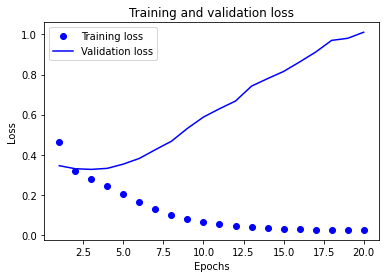

In [22]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

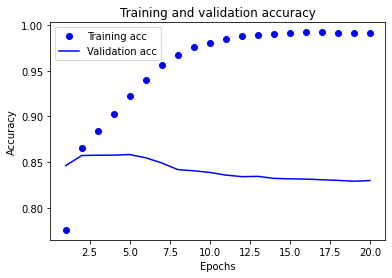

In [23]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 두번째 모델 : LSTM 모델

## 4) 모델 구성 및 validation set 구성


In [43]:
import tensorflow as tf

vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 32  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 323,281
Trainable params: 323,281
Non-trainable params: 0
_________________________________________________________________


## 5) 모델 훈련 개시


In [45]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 3s 7ms/step - loss: 0.0641 - accuracy: 0.9768 - val_loss: 1.0471 - val_accuracy: 0.8320
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.0598 - accuracy: 0.9783 - val_loss: 1.1114 - val_accuracy: 0.8331
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.0573 - accuracy: 0.9794 - val_loss: 1.1506 - val_accuracy: 0.8307
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.0576 - accuracy: 0.9794 - val_loss: 1.0981 - val_accuracy: 0.8338
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.0557 - accuracy: 0.9799 - val_loss: 1.1258 - val_accuracy: 0.8308
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.0569 - accuracy: 0.9795 - val_loss: 1.0869 - val_accuracy: 0.8290
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.0559 - accuracy: 0.9797 - val_loss: 1.1495 - val_accuracy: 0.8332
Epoch 

### 테스트셋 평가

In [46]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.4366 - accuracy: 0.8253
[1.4366010427474976, 0.8252944350242615]


## 6) Loss, Accuracy 그래프 시각화

In [47]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


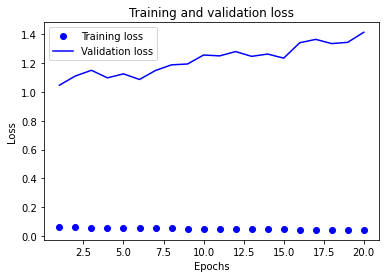

In [48]:
import matplotlib.pyplot as plt
plt.clf()   # 그림을 초기화합니다


acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

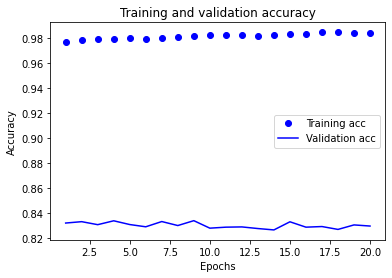

In [49]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 세번째 모델 : GlobalMaxPooling1D

## 4) 모델 구성 및 validation set 구성


In [37]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 32   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 320,273
Trainable params: 320,273
Non-trainable params: 0
_________________________________________________________________


## 5) 모델 훈련 개시


In [50]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 3s 7ms/step - loss: 0.0439 - accuracy: 0.9835 - val_loss: 1.4257 - val_accuracy: 0.8316
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.0416 - accuracy: 0.9848 - val_loss: 1.3785 - val_accuracy: 0.8279
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.0389 - accuracy: 0.9857 - val_loss: 1.4236 - val_accuracy: 0.8300
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.0369 - accuracy: 0.9862 - val_loss: 1.4555 - val_accuracy: 0.8281
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.0377 - accuracy: 0.9862 - val_loss: 1.5055 - val_accuracy: 0.8315
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.0413 - accuracy: 0.9845 - val_loss: 1.4364 - val_accuracy: 0.8286
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.0387 - accuracy: 0.9855 - val_loss: 1.4556 - val_accuracy: 0.8300
Epoch 

### 테스트셋 평가

In [51]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.7422 - accuracy: 0.8200
[1.7421869039535522, 0.8199849724769592]


## 6) Loss, Accuracy 그래프 시각화


In [52]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


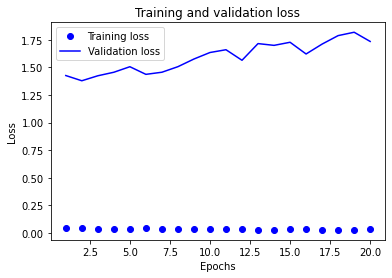

In [53]:
import matplotlib.pyplot as plt
plt.clf()   # 그림을 초기화합니다


acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

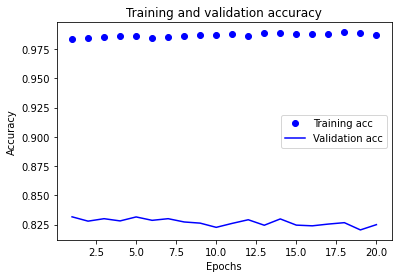

In [54]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 분석


**1-D CNN** : accuracy 0.82

**LSTM** : accuarcy 0.82

**GlobalMaxPooling1D** : 0.82

다 동일한 accuracy가 나왔고, 각각 좋은 효율이 나오진 않은것 같다.

## 7) 학습된 Embedding 레이어 분석


In [57]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


In [62]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [69]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 1. 특정 단어 임베딩 벡터 확인
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['로맨스']
vector

array([-0.06705967,  0.21102627, -0.25948802,  0.18721704, -0.06362781,
        0.06801855, -0.10730439, -0.12347036, -0.00373293, -0.01154001,
        0.03068266, -0.0083458 , -0.05800506, -0.09976672, -0.04866101,
       -0.0717878 , -0.02214791, -0.07830832, -0.09260057, -0.2152453 ,
        0.01162662,  0.0164805 , -0.04471913, -0.04131995, -0.03362889,
        0.15197599,  0.13258433,  0.0232328 ,  0.18020773, -0.22070424,
       -0.00798994,  0.12786043], dtype=float32)

In [70]:
# 2. 특정 단어 similarity 확인
word_vectors.similar_by_word("로맨스")

[('댄다', 0.8442665338516235),
 ('ㅜㅜ', 0.8184974789619446),
 ('로드리게즈', 0.7793420553207397),
 ('지닌', 0.7676672339439392),
 ('도다', 0.7670983672142029),
 ('교사', 0.7654435038566589),
 ('절정', 0.7548171281814575),
 ('단언', 0.750026285648346),
 ('생기', 0.7454838156700134),
 ('김승우', 0.7433567047119141)]

In [71]:
word_vectors.similar_by_word("액션")

[('ㄹ', 0.5818103551864624),
 ('어릴', 0.5548459887504578),
 ('오히려', 0.5397169589996338),
 ('딱딱', 0.5214800238609314),
 ('필요', 0.5180049538612366),
 ('사위', 0.515617311000824),
 ('그리고', 0.5041124820709229),
 ('주장', 0.5038052797317505),
 ('충실', 0.5033904910087585),
 ('보였', 0.4949555993080139)]

### 분석 : 눈에 띄는 유사성이 보이지는 않는다.

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선


In [77]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 1. word2vec_ko.model 가져오기
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

In [78]:
# 특정 단어 벡터 확인
vector = word_vectors.wv['로맨스']
print(vector)
print(vector.shape)

[-1.8797913  -1.3336711  -2.0093203   0.703664    0.36742678  1.4265652
 -3.088699   -3.225758   -0.35589305 -0.74962014  1.185361   -2.4044704
  0.26828375 -2.5341792  -0.5448657  -0.08026554 -0.80132926  1.1811965
  2.064575    0.5134578  -0.5183713   1.2469771   1.5423366  -1.7643833
 -0.6053416  -2.7293918   0.6429276   2.4069326   1.7524382  -1.4330237
 -2.4130747   0.11398019  2.6115131  -0.44127244  4.311872    3.3756168
 -2.7024162  -1.1524824  -3.0436184  -2.2596867   1.8034025  -1.3179646
  0.5284866   3.0003123   3.366214    1.1680667   3.4784677   0.7246252
 -1.1785473  -2.417907    0.24860694 -0.31804532  0.48554075 -2.542443
  1.8847829  -2.3313317   3.4848146  -1.1405562  -0.8876223  -1.1302168
  0.07882648 -0.50854015  2.2601905  -3.7017334   0.7708817   0.17844205
 -2.1321433  -0.7077454   0.73631096  0.77729183  0.7529262   2.1627305
  4.2411423   0.1594363   1.8375477  -2.2709656  -1.8658937   2.2542303
  0.07667899 -0.5594531   3.0330067   0.16907217 -0.67481107  1.

In [79]:
# 특정 단어 similarity 확인
word_vectors.wv.most_similar('로맨스', topn=10)

[('코미디', 0.7693179845809937),
 ('스릴러', 0.7384023666381836),
 ('미스터리', 0.6829106211662292),
 ('멜', 0.6484889388084412),
 ('판타지', 0.6426652669906616),
 ('서스펜스', 0.6392661929130554),
 ('로맨틱', 0.638347327709198),
 ('드라마', 0.6356117129325867),
 ('영화', 0.605586051940918),
 ('SF', 0.5966057181358337)]

### 분석
한국어 Word2Vec를 사용하니 더 직관적이고 이해 가능한 similarity를 발견할 수 있었다.

In [85]:
vocab_size = 10000  
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 word_vectors.wv 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [86]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim,
                        embeddings_initializer = Constant(embedding_matrix),
                        input_length = maxlen,
                        trainable = True))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [87]:
# 학습하기
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics=['accuracy'])
epochs = 20
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs = epochs,
                   batch_size = 512, validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/20
266/266 [==============================] - 3s 6ms/step - loss: 0.6180 - accuracy: 0.6570 - val_loss: 0.5074 - val_accuracy: 0.7544
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.4534 - accuracy: 0.7884 - val_loss: 0.4196 - val_accuracy: 0.8090
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3884 - accuracy: 0.8264 - val_loss: 0.3902 - val_accuracy: 0.8239
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3502 - accuracy: 0.8474 - val_loss: 0.3684 - val_accuracy: 0.8369
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3233 - accuracy: 0.8617 - val_loss: 0.3589 - val_accuracy: 0.8405
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3040 - accuracy: 0.8715 - val_loss: 0.3532 - val_accuracy: 0.8462
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2877 - accuracy: 0.8802 - val_loss: 0.3582 - val_accuracy: 0.8448
Epoch 

In [88]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.4996 - accuracy: 0.8365
[0.49955910444259644, 0.8364831209182739]


### 분석
1% 정도 정확도가 올랐지만, 큰 향상은 없어 모델의 구성에 문제가 있는거 같다.

## 회고
잘한 점 : 80% 이상 정확도를 내며 다양한 모델을 시도해 보았다.

못한 점 : 90% 이상 정확도를 내지 못해 성능 향상에 있어 아직 어려움을 갖고 있는거 같다.

노력할 점 : 모델의 성능 향상을 어떻게 하면 좋을지 이해하며 공부해볼 필요가 있다.